In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR, LambdaLR, CosineAnnealingLR
from torch.utils.data import DataLoader

from swag import SWAG
from models import SimpleNet, ConvNN, Classification_relu, Classification_sigmoid, Classification_tanh
from util import model_param_to_1D, params_1d_to_weights, create_NN_with_weights, plot_decision_boundary
from data_gen import ClassificationDataSet

torch.manual_seed(0)
np.random.seed(0)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Classification on a toy dataset

Since the paper proposed that the SWAG algorithm will be able to closely approximate the posterior of neural networks, we would like to apply this idea to a simple task of OOD detection. 

In the below section, we will apply SWAG to a really simple dataset borrowed from HW7 for OOD detection. Specifically, we have strategically selected a number of points to evaluate the model's ability to capture aleatoric and epistemic uncertainties. The expected behavior for the test points are described as the follows:
- `(-1, -1.5), (1, 1)`: in-distribution samples, should be classified corrected with high certainty
- `(-5, -5), (5, 5)`: OOD samples, should be assigned high uncertainty in prediction
- `(-5, 3.5), (5, -3.5)`: OOD samples, should be assigned high uncertainty in prediction. Note that these two points are roughly right on top of the linear decision boundary that separates the two classes, which means correctly assigning uncertainties is more challenging
- `(-1, 1), (1, -1)`: in-distribution samples, selected to evaluate the model's ability to capture aleatoric uncertainties since they lie on top of the two classes

In [2]:
# Create the training DataSet
train_data = ClassificationDataSet(n_samples=500, mode='train')
train_gen = DataLoader(dataset = train_data, batch_size = 8, shuffle = False)

X, y, X_test = train_data.X, train_data.Y.flatten(), train_data.test_points

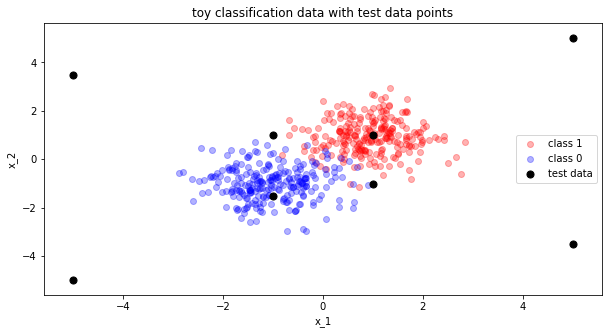

In [3]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(X_test)):
    pt = X_test[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')

In [4]:
# Take a look at the architecture of Classification_NN
Classification_relu()

Classification_relu(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=2, bias=True)
)

In [5]:
# Initialize SWAG
swag = SWAG(Classification_relu, K = 10)
print("Total number of parameters for the NN is:", swag.weigt_D)

Total number of parameters for the NN is: 42


In [6]:
# Compile swag
objective = 'classification'
lr = 1e-3
swa_const_lr = 1
momentum = 0.9
optimizer = optim.SGD
loss_fn = nn.CrossEntropyLoss()
swa_scheduler = LambdaLR

swag.compile(objective, lr, swa_const_lr, momentum, optimizer, loss_fn, swa_scheduler)

In [7]:
# Fit swag
first_mom, second_mom, D = swag.fit(train_gen,
                                    train_epoch=20,
                                    swag_epoch=20,
                                    log_freq=60)

Begin NN model training...
[Epoch: 1, 	Iteration:    60] 	Training Loss: 0.7299
[Epoch: 2, 	Iteration:    60] 	Training Loss: 0.6781
[Epoch: 3, 	Iteration:    60] 	Training Loss: 0.6303
[Epoch: 4, 	Iteration:    60] 	Training Loss: 0.5760
[Epoch: 5, 	Iteration:    60] 	Training Loss: 0.5259
[Epoch: 6, 	Iteration:    60] 	Training Loss: 0.4897
[Epoch: 7, 	Iteration:    60] 	Training Loss: 0.4638
[Epoch: 8, 	Iteration:    60] 	Training Loss: 0.4438
[Epoch: 9, 	Iteration:    60] 	Training Loss: 0.4278
[Epoch: 10, 	Iteration:    60] 	Training Loss: 0.4144
[Epoch: 11, 	Iteration:    60] 	Training Loss: 0.4034
[Epoch: 12, 	Iteration:    60] 	Training Loss: 0.3943
[Epoch: 13, 	Iteration:    60] 	Training Loss: 0.3868
[Epoch: 14, 	Iteration:    60] 	Training Loss: 0.3807
[Epoch: 15, 	Iteration:    60] 	Training Loss: 0.3758
[Epoch: 16, 	Iteration:    60] 	Training Loss: 0.3717
[Epoch: 17, 	Iteration:    60] 	Training Loss: 0.3684
[Epoch: 18, 	Iteration:    60] 	Training Loss: 0.3656
[Epoch: 19

## Uncertainty Measurement

One way to approximate the model uncertainty, is by measuring the variance (or standard deviation) of the model predictions for each point. We can repeatedly draw samples from the SWAG weights posterior to form a distribution over predictions for each point. The expected behavior is that, for the OOD points, the variance of predictions should be higher than for the in-sample points.

To assess the SWAG model, we wrote a function that perserves the predictions on all points using each sampled NN weights using the SWAG model, and then perform the uncertainty measurement.

In [8]:
# Sample 1000 posterior weights
expand_pred = swag.predict(torch.Tensor(X_test), [0, 1], S=100, expanded=True)
print("Shape of the expanded prediction:\n", expand_pred.shape)
print("Predictions for each point using the 1st sample weights:\n", expand_pred[0])

Shape of the expanded prediction:
 (100, 8, 2)
Predictions for each point using the 1st sample weights:
 [[9.94594038e-01 5.40592009e-03]
 [1.10650714e-03 9.98893559e-01]
 [9.99997735e-01 2.22854328e-06]
 [4.39286871e-11 1.00000000e+00]
 [9.89108205e-01 1.08917449e-02]
 [2.86664218e-02 9.71333623e-01]
 [4.11928236e-01 5.88071764e-01]
 [5.20301580e-01 4.79698390e-01]]


In [9]:
def uncertainty_measurement(X_test, expand_pred):
    ''' Params:
            X_test: test points
            expand_pred: swag prediction in expanded form
    '''
    var_list = []
    for i in range(len(X_test)):
        preds_i = np.argmax(expand_pred[:, i], axis=1)
        var_list.append(np.var(preds_i))

    print("\nBegin uncertainty assessment...")
    for x, var in zip(X_test, var_list):
        print(f"Test point: {x} \tVariance in prediction: {var:.4f}")

uncertainty_measurement(X_test, expand_pred)


Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0000
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0000
Test point: (-5, 3.5) 	Variance in prediction: 0.0000
Test point: (5, -3.5) 	Variance in prediction: 0.0000
Test point: (-1, 1) 	Variance in prediction: 0.2211
Test point: (1, -1) 	Variance in prediction: 0.2499


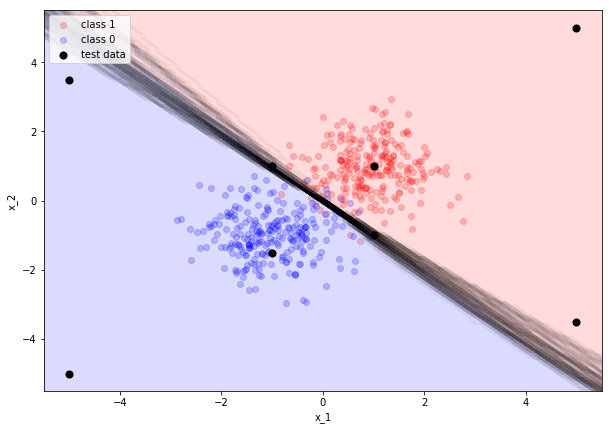

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plot_decision_boundary(swag, X, y, ax, xlim=6, n_models=100, poly_degree=1, test_points=X_test, shaded=True)

From the above uncertainty measurements, we see that the sampled weights from the posterior are too similar that the produced decision boundaries are almost identical. Additionally, the uncertainty measurement is positive only for the 2 data points that lie right on top of the decision boundary, while the 4 OOD points have no uncertainty whatsoever, which is undesirable.

To counter this problem, we will explore a number of possibilities
1. use different activation functions - the intuition is that different activation function will have different decision boundaries, some of which might produce better uncertainty measurements
2. perform the pre-training for less epochs - the idea is that if the pre-trained model is already overfitted, then the swag inference will tend to produce very similar results, so underfitting the pre-trained model could potentially produce more desirable uncertainty measurements
3. experiment with the learning rate for swag inference - the idea is that if we vary the learning rate during swag inference, the model might explore more or less of the subspace formed by the NN weights, which could yield better uncertainty measurements

## 1. Different activation functions

In [11]:
def swag_trainer(NN_class, swa_const_lr=1, train_epoch=20, xlim=6, n_models=100, verbose=False): 
    torch.manual_seed(47)
    np.random.seed(47)

    # Initialize SWAG
    swag = SWAG(NN_class, K = 10)
    print("Total number of parameters for the NN is:", swag.weigt_D)

    # Compile swag
    objective = 'classification'
    lr = 3e-2
    momentum = 0.9
    optimizer = optim.SGD
    loss_fn = nn.CrossEntropyLoss()
    swa_scheduler = LambdaLR

    swag.compile(objective, lr, swa_const_lr, momentum, optimizer, loss_fn, swa_scheduler)

    # Fit swag
    first_mom, second_mom, D = swag.fit(train_gen,
                                        train_epoch=train_epoch,
                                        swag_epoch=20,
                                        log_freq=60,
                                        verbose=verbose)

    # measure uncertainty
    expand_pred = swag.predict(torch.Tensor(X_test), [0, 1], S=100, expanded=True)
    uncertainty_measurement(X_test, expand_pred)
    
    # Plot decision boundary
    print("\nPlotting the decision boundaries...")
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plot_decision_boundary(swag, X, y, ax, xlim, n_models, poly_degree=1, test_points=X_test, shaded=True, )
    return swag

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0000
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0000
Test point: (-5, 3.5) 	Variance in prediction: 0.2176
Test point: (5, -3.5) 	Variance in prediction: 0.1924
Test point: (-1, 1) 	Variance in prediction: 0.0979
Test point: (1, -1) 	Variance in prediction: 0.2451

Plotting the decision boundaries...


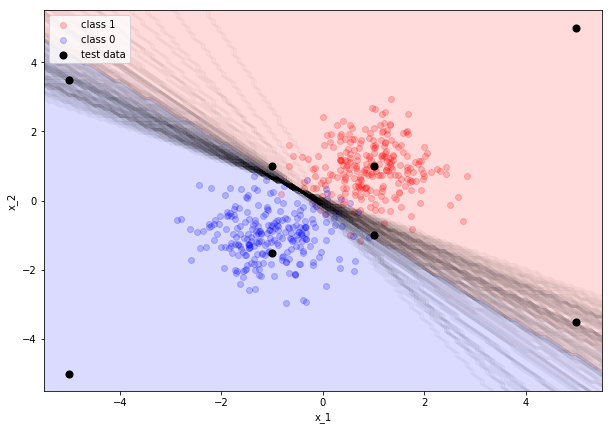

In [12]:
# Try sigmoid activation
swag = swag_trainer(Classification_sigmoid)

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0000
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0000
Test point: (-5, 3.5) 	Variance in prediction: 0.0000
Test point: (5, -3.5) 	Variance in prediction: 0.0000
Test point: (-1, 1) 	Variance in prediction: 0.0000
Test point: (1, -1) 	Variance in prediction: 0.0000

Plotting the decision boundaries...


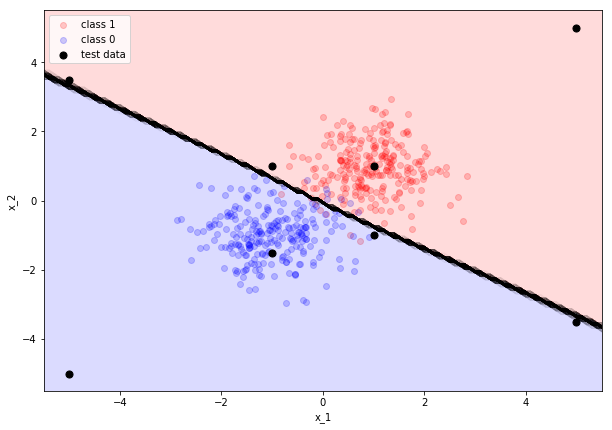

In [13]:
# Try tanh activation
swag = swag_trainer(Classification_tanh)

We can see from the above two visualization as well as the uncertainty measurements that, even though the decision boundaries produced by the sigmoid and tanh functions are different than those produced by the NN base model using relu activation, one predominant theme we still observe is that, if the neural network is overfitted to the dataset, the posterior weights sampled using SWAG tend to produce decision boundaries that are similarily tightly centered around the linear decision boundary that separates the two classes. 

At the same time, the uncertainty measures are not ideal, only capturing the uncertainties for `(-1, 1), (1, -1)`, which were designed to capture aleatoric uncertainties, and `(-5, 3.5), (5, -3.5)` (which lie on the extension of the linear decision boundary), which were designed to capture epistemic uncertainties. However, we notice that `(-5, -5), (5, 5)`, which are orthogonal to the linear decision boundary, have zero uncertainty, which means the SWAG model failed to capture these two OOD samples.

An additional observation is that, sometimes the two points which the model should have 0 confusion about, `(-1, -1.5), (1, 1)`, have non-zero uncertainty measurements. Some manual inspections reveals that, sometimes the weights drawn from the trained SWAG model tends are kind of unstable and renders the NN predicting all 1s or 0s for all observations. We have two hypotheses that could explain this observation:
1. for neural network models in general, the non-linear relationships between the neurons in the hidden layers are so complex that sometimes even a small tweek in the model weights will make the predictions non-sensible
2. due to the stochasticity of the SWAG model, sometimes the sampled the posterior weights could deviation from the pre-trained weights by a substantial amount that the re-constructed NN will produce non-sensible results

## 2. Underfitting the pre-trained model

Continuing with our experiment, we will now explore underfitting the pre-trained model to see if this will mitigate the undesirable uncertainty measurements. We will employ the `Classification_the sigmoid` model since, compared to the other two NNs, its ability to produce desirable uncertainty measurements is slightly better.

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0819
Test point: (1, 1) 	Variance in prediction: 0.1539
Test point: (-5, -5) 	Variance in prediction: 0.0384
Test point: (5, 5) 	Variance in prediction: 0.1539
Test point: (-5, 3.5) 	Variance in prediction: 0.2211
Test point: (5, -3.5) 	Variance in prediction: 0.2436
Test point: (-1, 1) 	Variance in prediction: 0.2016
Test point: (1, -1) 	Variance in prediction: 0.1875

Plotting the decision boundaries...


/Users/zihaoxu/ENTER/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


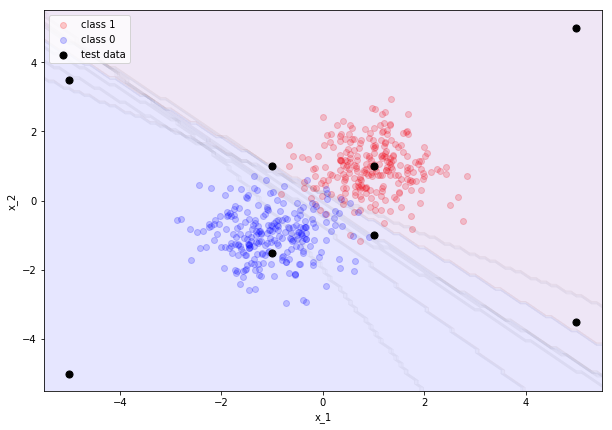

In [14]:
# Train for 5 epochs
swag = swag_trainer(Classification_sigmoid, train_epoch=5, n_models=10)

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0564
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0564
Test point: (-5, 3.5) 	Variance in prediction: 0.2331
Test point: (5, -3.5) 	Variance in prediction: 0.2451
Test point: (-1, 1) 	Variance in prediction: 0.1411
Test point: (1, -1) 	Variance in prediction: 0.2419

Plotting the decision boundaries...


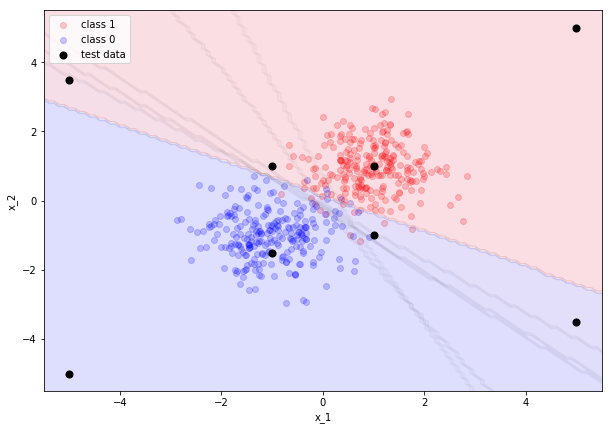

In [15]:
# Train for 10 epochs
swag = swag_trainer(Classification_sigmoid, train_epoch=10, n_models=10)

In [16]:
# Predicting all X_test
for i in range(20):
    preds = swag.predict(torch.Tensor(X_test), [0, 1], S=1, expanded=False)
    print("Trail", i, ', Predictions:', preds)

Trail 0 , Predictions: [0 1 0 1 1 0 1 0]
Trail 1 , Predictions: [0 1 0 1 1 0 1 0]
Trail 2 , Predictions: [0 1 0 1 0 1 1 1]
Trail 3 , Predictions: [0 1 0 1 0 1 1 1]
Trail 4 , Predictions: [0 1 0 1 1 0 1 0]
Trail 5 , Predictions: [0 1 0 1 1 0 1 0]
Trail 6 , Predictions: [0 1 0 1 0 1 1 0]
Trail 7 , Predictions: [0 1 0 1 0 1 1 1]
Trail 8 , Predictions: [0 1 0 1 0 1 1 1]
Trail 9 , Predictions: [0 1 0 1 0 1 1 1]
Trail 10 , Predictions: [0 1 0 1 1 0 1 0]
Trail 11 , Predictions: [0 1 0 1 1 0 1 0]
Trail 12 , Predictions: [0 1 0 1 0 1 1 1]
Trail 13 , Predictions: [0 0 0 0 0 0 0 0]
Trail 14 , Predictions: [0 1 0 1 0 1 0 0]
Trail 15 , Predictions: [0 1 0 1 0 1 1 0]
Trail 16 , Predictions: [0 1 0 1 0 1 1 1]
Trail 17 , Predictions: [0 1 0 1 1 0 1 0]
Trail 18 , Predictions: [0 1 0 1 0 1 1 0]
Trail 19 , Predictions: [0 1 0 1 0 1 1 0]


In [17]:
# Predicting just one point
pt = (1, 1)
point_pred = swag.predict(torch.Tensor(pt).view(1,-1), [0, 1], S=100, expanded=True)[:, 0, :]
point_pred = np.argmax(point_pred, axis=1)
print(f"For {pt}, mean prediction: {np.mean(point_pred):.4f}, var of predictions: {np.var(point_pred):.4f}")

pt = (5, 5)
point_pred = swag.predict(torch.Tensor(pt).view(1,-1), [0, 1], S=100, expanded=True)[:, 0, :]
point_pred = np.argmax(point_pred, axis=1)
print(f"For {pt}, mean prediction: {np.mean(point_pred):.4f}, var of predictions: {np.var(point_pred):.4f}")

For (1, 1), mean prediction: 0.9000, var of predictions: 0.0900
For (5, 5), mean prediction: 0.8700, var of predictions: 0.1131


From the above experiments, we find that underfitting the pre-tarined model is not a good idea. This is because even though underfitting might be able to produce more "curved" decision bounaries (which could be desirable), the recontructed NN also tends to be more unstable as the sampled posterior weights will produce enitrely non-sensible results such as predicting all 1s or all 0s for the test points. This is evident form the above two calulations:
- For repeated predictions of all test points, we see some big stability issues with the model since we observe some predictions to be all 0s or all 1s
- `(1, 1), (5, 5)` are two points that the model should seemingly be really certain of, but their uncertainties are not zero, which indicates that the model suffers from 

## 3. SWAG learning rate

Another paramter that we could experiment with is the learning rate during SWAG inference. In the original paper, the author proposed using a constant learning rate for the SWAG inference to explore the subspace formed by the posterior of NN weights. In our original implementation, we used a constant learning rate of 1, but now we could try larger learning rates to see if the exploration could be more thorough.

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0000
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0000
Test point: (-5, 3.5) 	Variance in prediction: 0.2176
Test point: (5, -3.5) 	Variance in prediction: 0.1924
Test point: (-1, 1) 	Variance in prediction: 0.0979
Test point: (1, -1) 	Variance in prediction: 0.2451

Plotting the decision boundaries...


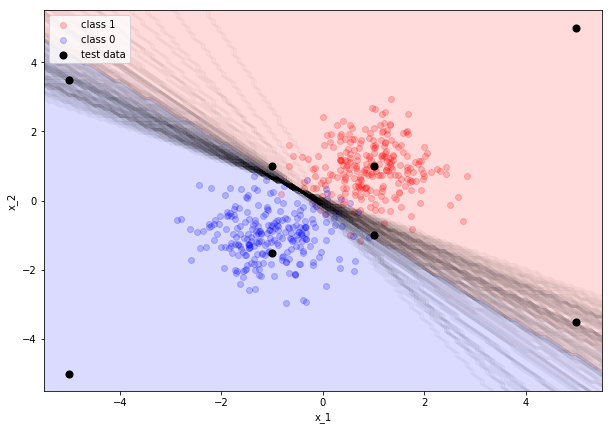

In [18]:
swag = swag_trainer(Classification_sigmoid)

In [ ]:
swag = swag_trainer(Classification_sigmoid, swa_const_lr=0.1)

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0196
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0196
Test point: (-5, 3.5) 	Variance in prediction: 0.2491
Test point: (5, -3.5) 	Variance in prediction: 0.2244
Test point: (-1, 1) 	Variance in prediction: 0.0651
Test point: (1, -1) 	Variance in prediction: 0.2484

Plotting the decision boundaries...


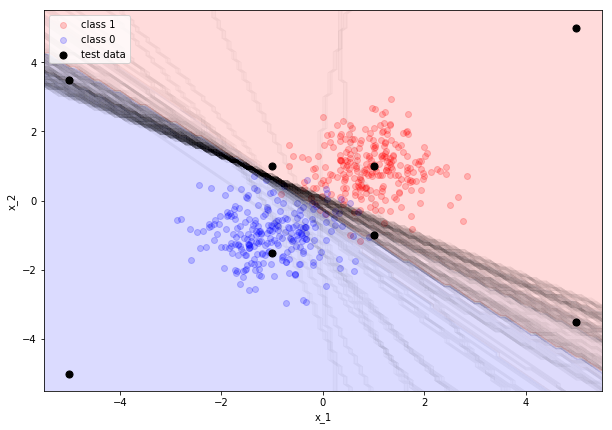

In [19]:
swag = swag_trainer(Classification_sigmoid, swa_const_lr=3)

Total number of parameters for the NN is: 42
Begin NN model training...

Begin SWAG training...

Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0819
Test point: (1, 1) 	Variance in prediction: 0.0196
Test point: (-5, -5) 	Variance in prediction: 0.0475
Test point: (5, 5) 	Variance in prediction: 0.0196
Test point: (-5, 3.5) 	Variance in prediction: 0.1924
Test point: (5, -3.5) 	Variance in prediction: 0.2379
Test point: (-1, 1) 	Variance in prediction: 0.0196
Test point: (1, -1) 	Variance in prediction: 0.2496

Plotting the decision boundaries...


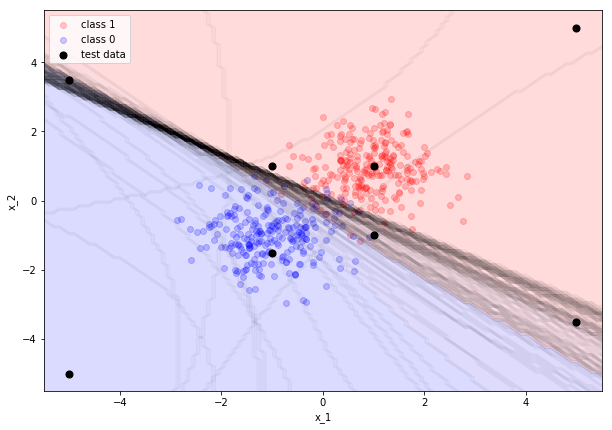

In [20]:
swag = swag_trainer(Classification_sigmoid, swa_const_lr=5)

From the above results, we see that change the SWAG inference learning rate can only amplify the test points that already have a reasonable uncertainty, but cannot correctly assign uncertainties to those points that should have been assigned a non-trival uncertainty. Also, if the learning rate is too large, the resulting model is highly unstable, making all uncertainty measurements non-sensible.

## Conclusion

In the above section, we have thoroughly explore the ability of SWAG to produce uncertainty measurements. The overall result is not perfect, as the model is only able to capture aleatoric uncertainty (as well as those points that happen to lie right on top of the linear decision boundary), but not the epistemic uncertainty for OOD test points.

This analysis points out several important limitations of the SWAG algorithm:
- Due to the "black box" nature of NN models, it is hard for us to understand the effect of changing the model parametersm which means the expected behavior of approximating the posterior of NN weights as a multivariate normal distirbution and then sample from it is very hard to predict. As we have seen from the examples above, the re-constrcuted model using a sampled weights could sometimes be highly unstable and yield non-sensible predictions like all 0s or all 1s
- It is well know that NN models tend to overfit to the training data, and this is indeed what we observe. If the pre-trained model is too overfitted, then the SWAG inference step could only produce models that are very similar to the original model, which undermines the SWAG model's ability to capture the desired amount of uncertainty
- The ability of the SWAG model to capture uncertainty is ultimately bounded by the shape of decision boundaries that the original NN could form. To better capture uncertainty for this particular toy dataset, we should probably use higher order polynomial transformation of the features.